In [3]:
import pprint
from collections import defaultdict

import binance.exceptions
import requests

from binance import Client, ThreadedWebsocketManager, ThreadedDepthCacheManager

import pandas as pd

pd.set_option('display.max_rows', 15)
pd.set_option('display.min_rows', 15)

import datetime

import time

import csv

import matplotlib.pyplot as plt

import numpy as np
import dataframe_image as dfi


In [2]:
client = Client('', '') # Insert Binance API Key
API_KEY = "" #Insert Etherscan API Key
START = 0
END = 14962372
DONATION_ADDRESS = "0x165CD37b4C644C2921454429E7F9358d18A45e14"

HIST_PRICES = {}
STABLES = ["BNB", "USDC", "USDT", "DAI", "FEI", "USDT"]

In [3]:
#######
#BTC @ Blockchain.com
######

def query_blockchainCom_api(adress,offset):
    query = f"https://blockchain.info/rawaddr/{adress}?format=json&offset={offset}&limit=50"
    result = requests.get(query)
    txs = result.json()["txs"]
    return txs

def get_BTC_txs(adress):
    offset = 0
    
    txs = query_blockchainCom_api(adress,str(offset))
    final_txs = txs
    print(f'first Batch {offset} - {offset +50}')
    offset += 50
    time.sleep(4)
    
    while len(txs) == 50:
        txs = query_blockchainCom_api(adress,str(offset))  
        final_txs.extend(txs)
        print(f'next Batch {offset} - {offset +50}')
        offset += 50
        time.sleep(4)
        
    return final_txs

#######
#ETH @ Etherscan.io
######

def query_api(start, end, action):
    query = f"https://api.etherscan.io/api?module=account&action={action}&address={DONATION_ADDRESS}&startblock={start}&endblock={end}&sort=asc&apikey={API_KEY}"
    result = requests.get(query)
    txs = result.json()["result"]
    return txs


def get_erc20():
    txs = query_api(START, END, "tokentx")
    last_block = txs[-1]["blockNumber"]
    clean_txs = [tx for tx in txs if tx["blockNumber"] != last_block]
    second_batch = query_api(last_block, END, "tokentx")
    clean_txs.extend(second_batch)
    incoming_txs = [tx for tx in clean_txs if tx["to"] == DONATION_ADDRESS.lower() and tx["from"] != DONATION_ADDRESS.lower() and int(tx["value"]) > 0] #originally this line was not there
    print(len(incoming_txs)) # originally was clean_txs
    return incoming_txs # originally was clean_txs


def get_erc721():
    txs = query_api(START, END, "tokennfttx")
    print(len(txs))
    return txs


def get_erc1155():
    txs = query_api(START, END, "token1155tx")
    print(len(txs))
    return txs


def get_eth():
    last_block = START
    all_txs = []

    while True:
        txs = query_api(last_block, END, "txlist")
        last_block = txs[-1]["blockNumber"]
        clean_txs = [tx for tx in txs if tx["blockNumber"] != last_block]
        all_txs.extend(clean_txs)
        if len(txs) < 10000:
            break

    incoming_txs = [tx for tx in all_txs if tx["to"] == DONATION_ADDRESS.lower() and tx["from"] != DONATION_ADDRESS.lower() and int(tx["value"]) > 0]
    print("All txs", len(all_txs))
    print("Incoming tx", len(incoming_txs))
    return incoming_txs




def process_erc20(txs):
    
    results_list=[]
    tokens = defaultdict(int)
    i = 0
    for tx in txs:
        token = tx["tokenSymbol"]
        if token == "WETH":
            token = "ETH"
        if token == "WBTC":
            token = "BTC"
            
        amount = int(tx["value"]) / (10 ** int(tx["tokenDecimal"]))
        if token in STABLES:
            spot = 1.0
        else:
            spot = get_historical_price(token, int(tx["timeStamp"]) * 1000)
        try:
            tokens[token] += float(spot) * float(amount)
        except:
            continue

        # print(f"{amount} {token} @ {spot}: {float(amount) * float(spot)}")
        # progress
        if i % 100 == 0:
            print(f"{i}/{len(txs)}")
        i += 1
        
        results_list.append([int(tx["timeStamp"]),amount,token,float(spot) * float(amount)])

    tokens = {k: v for k, v in tokens.items() if v > 0}
    tokens_sorted = {k: v for k, v in sorted(tokens.items(), key=lambda item: float(item[1]), reverse=True)}
    pprint.pprint(tokens_sorted)
        # tokens[tx["tokenSymbol"]] += int(tx["value"]) / (10 ** int(tx["tokenDecimal"]))
        # tokentime[]
    # tokens_sorted = {k: v for k, v in sorted(tokens.items(), key=lambda item: item[0])}
    # pprint.pprint(tokens_sorted)

    
    df =pd.DataFrame(results_list, columns =['timestamp','amount','ticker','USD value at donation time'])
    df['USD value at donation time'] = df['USD value at donation time'].round(decimals = 2)
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')    
    
    return df

def process_eth(txs):
    total = 0
    
    results_list=[]

    for tx in txs:
        amount = int(tx["value"]) / (10 ** 18)
        spot = get_historical_price("ETH", int(tx["timeStamp"]) * 1000)
        donation_in_usd = float(spot) * float(amount)
        total += donation_in_usd
        results_list.append([int(tx["timeStamp"]),amount,'ETH',donation_in_usd])

    df =pd.DataFrame(results_list, columns =['timestamp','amount','ticker','USD value at donation time'])
    df['USD value at donation time'] = df['USD value at donation time'].round(decimals = 2)
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

    return df



#######
#Prices @ Binance
######

def get_historical_price(token, timestamp):
    if token not in HIST_PRICES:
        pair = f"BUSD{token}"
        try:
            klines = client.get_historical_klines(pair, Client.KLINE_INTERVAL_1HOUR, "1 Feb, 2022")
        except binance.exceptions.BinanceAPIException:
            pair = f"{token}BUSD"
            try:
                klines = client.get_historical_klines(pair, Client.KLINE_INTERVAL_1HOUR, "1 Feb, 2022")
            except binance.exceptions.BinanceAPIException:
                HIST_PRICES[token] = "invalid token"
                return 0

        open_data = [l[:2] for l in klines]
        HIST_PRICES[token] = open_data

    if HIST_PRICES[token] == "invalid token":
        return 0

    # print(HIST_PRICES[token])
    for date_price in HIST_PRICES[token]:
        if date_price[0] > timestamp:
            return date_price[1]

# ETH

In [4]:
eth_txs = get_eth()

All txs 73852
Incoming tx 73434


In [5]:
donations_ETH_df = process_eth(eth_txs)
donations_ETH_df

,timestamp,amount,ticker,USD value at donation time
0,2022-02-26 11:54:48,0.014468,ETH,39.83
1,2022-02-26 11:55:24,0.014688,ETH,40.44
2,2022-02-26 11:56:16,0.200000,ETH,550.60
3,2022-02-26 12:00:40,0.036306,ETH,100.34
4,2022-02-26 12:05:18,0.093750,ETH,259.10
5,2022-02-26 12:08:27,0.021812,ETH,60.28
6,2022-02-26 12:09:14,1.229000,ETH,3396.69
...,...,...,...,...
73427,2022-06-13 10:47:31,0.041000,ETH,49.99
73428,2022-06-13 23:30:26,0.035000,ETH,42.27


In [6]:
donations_ETH_df.to_pickle('donations_ETH_df')

# ERC 20

In [7]:
erc20_txs = get_erc20()

5140


In [8]:
donations_ERC20_df = process_erc20(erc20_txs)
donations_ERC20_df

0/5140
100/5140
200/5140
300/5140
400/5140
500/5140
600/5140
700/5140
800/5140
900/5140
1000/5140
1100/5140
1200/5140
1300/5140
1400/5140
1500/5140
1600/5140
1700/5140
1800/5140
1900/5140
2000/5140
2100/5140
2200/5140
2300/5140
2400/5140
2500/5140
2600/5140
2700/5140
2800/5140
2900/5140
3000/5140
3100/5140
3200/5140
3300/5140
3400/5140
3500/5140
3600/5140
3700/5140
3800/5140
3900/5140
4000/5140
4100/5140
4200/5140
4300/5140
4400/5140
4500/5140
4600/5140
4700/5140
4800/5140
4900/5140
5000/5140
5100/5140
{'1INCH': 357.8835507661764,
 'AAVE': 254.38400692299996,
 'AERGO': 0.402,
 'AKRO': 614.25,
 'API3': 29.781851204819997,
 'BAL': 11653.117370803311,
 'BAT': 433.02339722872995,
 'BNT': 257.4752264136684,
 'BTC': 155.805198206,
 'CHZ': 10.057012542864001,
 'CLV': 0.9863280365600001,
 'COMP': 24.521360660852757,
 'CRV': 10.01171875,
 'DAI': 1073198.3029627907,
 'DIA': 15.971571789026125,
 'ENJ': 38.658,
 'ENS': 3318.6185770606266,
 'ETH': 32917.846212968376,
 'FLUX': 13.51,
 'FRONT': 0.825

,timestamp,amount,ticker,USD value at donation time
0,2022-02-26 12:29:21,100.000000,USDC,100.00
1,2022-02-26 12:58:39,200.000000,USDT,200.00
2,2022-02-26 13:00:43,501.000000,DAI,501.00
3,2022-02-26 14:51:12,12312.000000,PKG,0.00
4,2022-02-26 14:51:45,100.000000,USDT,100.00
5,2022-02-26 14:54:04,5000.000000,USDT,5000.00
6,2022-02-26 15:00:16,1000.000000,USDT,1000.00
...,...,...,...,...
5131,2022-06-08 13:27:57,312900.000000,XDB,0.00
5132,2022-06-08 14:55:00,999000.000000,XDB,0.00


In [9]:
donations_ERC20_df.to_pickle('donations_ERC20_df')

# Cryptopunks

### Cryptopunks NFT  ERC20

In [10]:
pd.options.display.max_colwidth = 100
punks = pd.DataFrame(erc20_txs)
punks = punks[(punks['tokenSymbol'] == "Ͼ")]
punks

,blockNumber,timeStamp,hash,nonce,blockHash,from,contractAddress,to,value,tokenName,tokenSymbol,tokenDecimal,transactionIndex,gas,gasPrice,gasUsed,cumulativeGasUsed,input,confirmations
1522,14303023,1646163297,0x76458c5226e06e55df2087f0595aed04d86debade3caa48180d1e835692f37e3,75,0x00bef4025777302ac5f56bdfb17bd0fdb0ba66120f52b5f0e90f3cbcfddfe07c,0x67c4438c86c00257d3bca9bbfb3f6234bc961468,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,0x165cd37b4c644c2921454429e7f9358d18a45e14,1,CRYPTOPUNKS,Ͼ,0,7,200000,122000000000,65391,967662,deprecated,670743


In [11]:
punks.to_pickle('punks')

First Transaction 
https://etherscan.io/tx/0x76458c5226e06e55df2087f0595aed04d86debade3caa48180d1e835692f37e3
https://cryptopunks.app/cryptopunks/details/5364



In [13]:
dfi.export(punks,"punks.png", table_conversion='matplotlib')


findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


# ERC-721

In [14]:
ERC721 = get_erc721()

ERC721_df = pd.DataFrame(ERC721)

1613


In [15]:
ERC721_df.tokenName.unique()

array(['Ethereum Name Service', 'Demonized Azuki', 'Mutant Floki',
       'Stonks', 'MetaPhox', 'ShibElon', 'SecretSocietyNFT',
       'Generative Floydies 2', 'SmolPhunks', 'Goat Soup',
       'Chubbiverse Frens', 'Acclimated\u200bMoonCats', 'BeaNFT Genesis',
       'KRebels', 'KnownOriginDigitalAsset', 'Mao', 'On-Chain Monsters',
       'Gucci', 'Elon Musk', 'InvisibIe Friends', 'ODDWORLDS',
       'Power Musix Club', 'Louis Vuitton', 'Zora', 'The Valkyries NFT',
       'CorinnaDAO', 'Bloxian #', 'Cyber Koala Collective',
       'Loot (for mfers)', 'The Repus', 'Lord Angels', 'Shields',
       'Typical Tigers', 'Nishikigoi', 'Doockles', 'Pixel Azuki',
       'Visitors of Imma Degen', 'Larva Wolf', '0xWOW', 'Toad Punks',
       'mfer', 'GLICPIXXXVER002 - GRAND COLLECTION',
       'BASTARD GAN PUNKS V2', 'NFT AIA', 'Basic Buns', 'WenChangeDAO',
       'Fury of the Fur', 'DoodMfers', 'Rarible', 'Givenchy', 'Coca Cola',
       'Lamborghini', 'Gnomenclature', 'Jeet Punks', 'Sushi Nekko',


# ERC-1155

In [16]:
ERC1155 = get_erc1155()

ERC1155_df = pd.DataFrame(ERC1155)

221


In [17]:
ERC1155_df.tokenName.unique()

array(['OpenSea Shared Storefront', '', 'Rarible', 'StandWithUkraine',
       'Orthoverse', 'Ukraine Freedom Fund Universal', 'Gucci',
       'BAYC Otherside Land', 'APPLE', 'G-Star RAW', 'Nintendo'],
      dtype=object)

# BTC

https://bitcoin.stackexchange.com/questions/108254/how-can-i-retrieve-all-transactions-for-an-address-using-the-blockchain-api


Cycle through all offsets untill all txs are there

https://blockchain.info/rawaddr/357a3So9CbsNfBBgFYACGvxxS6tMaDoa1P?format=json&offset=50&limit=50


In [18]:
BTC_ADRESS = "357a3So9CbsNfBBgFYACGvxxS6tMaDoa1P"


In [19]:
BTC_Transactions = get_BTC_txs(BTC_ADRESS)

first Batch 0 - 50
next Batch 50 - 100
next Batch 100 - 150
next Batch 150 - 200
next Batch 200 - 250
next Batch 250 - 300
next Batch 300 - 350
next Batch 350 - 400
next Batch 400 - 450
next Batch 450 - 500
next Batch 500 - 550
next Batch 550 - 600
next Batch 600 - 650
next Batch 650 - 700
next Batch 700 - 750
next Batch 750 - 800
next Batch 800 - 850
next Batch 850 - 900
next Batch 900 - 950
next Batch 950 - 1000
next Batch 1000 - 1050
next Batch 1050 - 1100
next Batch 1100 - 1150
next Batch 1150 - 1200
next Batch 1200 - 1250
next Batch 1250 - 1300
next Batch 1300 - 1350
next Batch 1350 - 1400
next Batch 1400 - 1450
next Batch 1450 - 1500
next Batch 1500 - 1550
next Batch 1550 - 1600
next Batch 1600 - 1650
next Batch 1650 - 1700
next Batch 1700 - 1750
next Batch 1750 - 1800
next Batch 1800 - 1850
next Batch 1850 - 1900
next Batch 1900 - 1950
next Batch 1950 - 2000
next Batch 2000 - 2050
next Batch 2050 - 2100
next Batch 2100 - 2150
next Batch 2150 - 2200
next Batch 2200 - 2250
next Ba

next Batch 17300 - 17350
next Batch 17350 - 17400
next Batch 17400 - 17450
next Batch 17450 - 17500
next Batch 17500 - 17550
next Batch 17550 - 17600
next Batch 17600 - 17650
next Batch 17650 - 17700
next Batch 17700 - 17750
next Batch 17750 - 17800
next Batch 17800 - 17850
next Batch 17850 - 17900
next Batch 17900 - 17950
next Batch 17950 - 18000
next Batch 18000 - 18050
next Batch 18050 - 18100
next Batch 18100 - 18150
next Batch 18150 - 18200
next Batch 18200 - 18250
next Batch 18250 - 18300
next Batch 18300 - 18350
next Batch 18350 - 18400
next Batch 18400 - 18450
next Batch 18450 - 18500
next Batch 18500 - 18550
next Batch 18550 - 18600
next Batch 18600 - 18650
next Batch 18650 - 18700


In [20]:
BTC_Transactions_df = pd.DataFrame(BTC_Transactions)
BTC_Transactions_df

,hash,ver,vin_sz,vout_sz,size,weight,fee,relayed_by,lock_time,tx_index,double_spend,time,block_index,block_height,inputs,out,result,balance
0,e59161030eb04fd66bbe75d2f83487e267c4b633fb1e1ccbbf0a366657cf5a44,2,3,4,610,1471,8141,0.0.0.0,741028,2405018123421377,False,1655371891,741029,741029,"[{'sequence': 4294967294, 'witness': '0247304402203dc23229f7a5582f5c8aaa50677c9757f0a3ddef6a8f91...","[{'type': 0, 'spent': True, 'value': 1181901, 'spending_outpoints': [{'tx_index': 35244083814682...",200000,12457064
1,7318bb8899fdd4ee5c271505c323e32fdd64ffca08a6a7b872ae741295f1d2a7,2,1,1,192,441,774,0.0.0.0,740930,5904782017580693,False,1655309858,740932,740932,"[{'sequence': 4294967293, 'witness': '02473044022004fe748ed8868e747e05c9fafcf19ffa141d6ff688a5c2...","[{'type': 0, 'spent': False, 'value': 73845, 'spending_outpoints': [], 'n': 0, 'tx_index': 59047...",73845,12257064
2,6becfee4366f14fb92f2b1972686633582fe4bf444e78d779811743cd4816c4a,1,1,1,193,442,2442,0.0.0.0,0,2618556642987650,False,1655309755,740931,740931,"[{'sequence': 0, 'witness': '02483045022100a0003f3414b4794250cf2d53bfadc42d7c954ad26f65558d83bb5...","[{'type': 0, 'spent': False, 'value': 356558, 'spending_outpoints': [], 'n': 0, 'tx_index': 2618...",356558,12183219
3,cca9608b8b3f08f055ab191f58abf3b0bb8913ffdfc6d04e85d3967a4e6cab76,1,1,63,2199,8469,44750,0.0.0.0,0,4175316114166490,False,1655309709,740931,740931,"[{'sequence': 4294967295, 'witness': '024730440220053b74d371e3537aad499d806136e0ea44e4c21863ede5...","[{'type': 0, 'spent': True, 'value': 961758, 'spending_outpoints': [{'tx_index': 343853942502590...",117164,11826661
4,9001f9ebc205a89f0ab19ca3e787f80a152a13f76fced39f602d6b03c67dceb5,2,1,22,1041,3402,18834,0.0.0.0,0,6396751296621925,False,1655298049,740910,740910,"[{'sequence': 4294967293, 'witness': '040047304402205c9e4dac9272831bf52c04645271ce45eb60bd72d605...","[{'type': 0, 'spent': True, 'value': 118651, 'spending_outpoints': [{'tx_index': 859241931452968...",163274,11709497
5,7fa537d5ec44cab1dfe4b126ed62a475eb27a37ec99031b451bd7dddd6d7ba43,2,1,1,192,441,143,0.0.0.0,740849,2383032453148599,False,1655270140,740851,740851,"[{'sequence': 4294967293, 'witness': '0247304402201fb075638d32ce721fa550b77f81270e14b5c9eeedca10...","[{'type': 0, 'spent': False, 'value': 30722, 'spending_outpoints': [], 'n': 0, 'tx_index': 23830...",30722,11546223
6,f84dcbbe087cc1ddd011be7612898a10fa2095e19392ff2e058039a029c161c1,1,1,35,1303,4882,23330,0.0.0.0,0,6804019095013168,False,1655185927,740718,740718,"[{'sequence': 4294967295, 'witness': '02483045022100df2757e184424407bb73a4e689878e2b2af0910a5051...","[{'type': 0, 'spent': True, 'value': 1684544, 'spending_outpoints': [{'tx_index': 34096737149534...",12610,11515501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18652,b757d92468fb4e3e6e2a5f3e09366afe041f875902cd63afb70bb84440841573,1,1,32,1192,4441,9968,0.0.0.0,0,4049160009979649,False,1645877752,725000,725000,"[{'sequence': 4294967295, 'witness': '02473044022023e13b1214d06d948f8c500b78c28559d0705f3972c215...","[{'type': 0, 'spent': True, 'value': 1620000, 'spending_outpoints': [{'tx_index': 75744793838338...",398767,15966511
18653,4518e24b0c2e0af57ce2dfb2c583ad766d7afd0111738541903d590c73c7bee1,2,1,2,247,661,1660,0.0.0.0,724999,7942704199732007,False,1645877752,725000,725000,"[{'sequence': 4294967293, 'witness': '0247304402204c083356ac9b149961f03664d55befa60f59463f46a331...","[{'type': 0, 'spent': True, 'value': 63859, 'spending_outpoints': [{'tx_index': 7160664167463907...",63859,15567744


In [21]:
#Dropping columns and converting from sat to btc
pd.options.display.max_colwidth = 100
BTC_Transactions_cleaned_df = BTC_Transactions_df.drop(['vout_sz', 'fee','tx_index','ver','vin_sz', 'size', 'weight','lock_time','block_index','relayed_by','double_spend', 'inputs','out'], axis=1)
BTC_Transactions_cleaned_df['result'] = BTC_Transactions_cleaned_df['result'] / (1.0 * 10**(8))
BTC_Transactions_cleaned_df['balance'] = BTC_Transactions_cleaned_df['result'] / (1.0 * 10**(8))

## Fetch Binance Prices for each Transaction

In [24]:
btcprices = []

for i in range (len(BTC_Transactions_cleaned_df)):
    tx_ammount = BTC_Transactions_cleaned_df.iloc[i, 3]
    tx_timestamp = BTC_Transactions_cleaned_df.iloc[i, 1]
    spot_price_value = get_historical_price('BTC', int(tx_timestamp) * 1000)
    spot_USD_Value = (tx_ammount * float(spot_price_value)).round(decimals = 2)
    btcprices.append(spot_USD_Value)
btcprices

BTC_Transactions_cleaned_df['USD_Value at Donation time'] = btcprices


### Cleaning up, negative & positive inputs

In [2]:
#Negative Transactions are there too
#BTC_Transactions_cleaned_df[BTC_Transactions_cleaned_df["hash"] == 'b9670b1b04f559d8f48da7f1f5e49f1b04ed067a3d2e5815d4f369bf8c81138e']['result'] 

BTCInputTXs = BTC_Transactions_cleaned_df[BTC_Transactions_cleaned_df['result']>0]
BTCOutputTXs = BTC_Transactions_cleaned_df[BTC_Transactions_cleaned_df['result']<0]
BTCNeutralTXs = BTC_Transactions_cleaned_df[BTC_Transactions_cleaned_df['result']==0]

btc_input = BTCInputTXs['result'].sum()
btc_output =BTCOutputTXs['result'].sum()
print(f'BTC Input Transactions are   {btc_input}. \nBTC Output Transactions are {btc_output}. \nCheck Values here: https://www.blockchain.com/btc/address/357a3So9CbsNfBBgFYACGvxxS6tMaDoa1P')

NameError: name 'BTC_Transactions_cleaned_df' is not defined

In [26]:
BTC_Transactions_cleaned_df.to_pickle('BTC_Transactions_cleaned_df')
BTCInputTXs.to_pickle('BTCInputTXs')
BTCOutputTXs.to_pickle('BTCOutputTXs')

# Final Results

### importing pickles

In [4]:
donations_ETH_df = pd.read_pickle('donations_ETH_df')
donations_ERC20_df = pd.read_pickle('donations_ERC20_df')
BTCInputTXs = pd.read_pickle('BTCInputTXs')


## Total Donations

In [5]:
total_Donations = []


### BTC

In [6]:
total_Donations.append(['BTC',BTCInputTXs['result'].sum(),BTCInputTXs['USD_Value at Donation time'].sum()])
total_Donations

[['BTC', 479.90741358, 19621510.77]]

### ETH

In [7]:
total_Donations.append(['ETH',donations_ETH_df['amount'].sum(),donations_ETH_df['USD value at donation time'].sum()])

total_Donations

[['BTC', 479.90741358, 19621510.77], ['ETH', 7723.819765805032, 22545519.85]]

### ERC-20

In [8]:
ERC20_currencies = donations_ERC20_df.ticker.unique()

donations_ERC20_df[(donations_ERC20_df['ticker'] == 'USDC')]

for i in range (len(ERC20_currencies)):
    
    ticker = ERC20_currencies[i]
    
    sum_amount = donations_ERC20_df[(donations_ERC20_df['ticker'] == ticker)]['amount'].sum()
    
    sum_usd_value = donations_ERC20_df[(donations_ERC20_df['ticker'] == ticker)]['USD value at donation time'].sum()
    print(f'ticker {ticker} sum amount {sum_amount} sum usd value {sum_usd_value}')
    total_Donations.append([ticker,sum_amount,sum_usd_value])



ticker USDC sum amount 1203278.136804 sum usd value 1203278.16
ticker USDT sum amount 7750877.755669 sum usd value 7750877.78
ticker DAI sum amount 1073198.3029627907 sum usd value 1073198.2999999998
ticker PKG sum amount 12312.0 sum usd value 0.0
ticker MDT sum amount 10000.0 sum usd value 578.4
ticker SAITOKI sum amount 3580564976.15271 sum usd value 0.0
ticker PEOPLE sum amount 1100.0 sum usd value 77.03999999999999
ticker API3 sum amount 4.54476594 sum usd value 29.78
ticker eMTRG sum amount 18.88 sum usd value 0.0
ticker KNDX sum amount 1.0 sum usd value 0.0
ticker RFX sum amount 150000.0 sum usd value 0.0
ticker MIC sum amount 0.000108594431914455 sum usd value 0.0
ticker DSD sum amount 63.55204319561544 sum usd value 0.0
ticker AWO sum amount 100.0 sum usd value 0.0
ticker CUMINU sum amount 0.001624166539420776 sum usd value 0.0
ticker STRM sum amount 13.621779059707755 sum usd value 0.0
ticker SXP sum amount 2.97411117715856 sum usd value 3.83
ticker bWETH sum amount 1.7e-17 su

ticker $HSUKRAINE sum amount 0.9 sum usd value 0.0
ticker CRYN sum amount 10.0 sum usd value 0.0
ticker Dior sum amount 2925041283047.277 sum usd value 0.0
ticker Cartier sum amount 2959847517469.441 sum usd value 0.0
ticker IBM sum amount 2340534211459.535 sum usd value 0.0
ticker UKRHODL sum amount 540796.241274107 sum usd value 0.0
ticker PASS sum amount 874854750.9 sum usd value 0.0
ticker FPC sum amount 17.35 sum usd value 0.0
ticker FLUX sum amount 10.0 sum usd value 13.51
ticker DELL sum amount 3926699417419.1387 sum usd value 0.0
ticker BMW sum amount 3201566869819.875 sum usd value 0.0
ticker LNP sum amount 90000000000.0 sum usd value 0.0
ticker xSUSHI sum amount 2.6262997660072456 sum usd value 0.0
ticker CLIFF sum amount 1000000000.0 sum usd value 0.0
ticker FRX sum amount 10000.0 sum usd value 0.0
ticker USDP sum amount 500.0 sum usd value 500.0
ticker ERC20 sum amount 2.97 sum usd value 0.0
ticker KIEV sum amount 500000000.0 sum usd value 0.0
ticker CBX sum amount 253.2 su

## Grouped into Top 4 and producing Pie Chart

In [9]:
final_results = pd.DataFrame(total_Donations).sort_values(by=[2], ascending=False)
final_results.rename(columns = {0:'Ticker', 1:'Total Amount (nominal)', 2:'Total Amount (USD value at donation time)'}, inplace = True)
pd.set_option("display.max_rows", None, "display.max_columns", None)
final_results

,Ticker,Total Amount (nominal),Total Amount (USD value at donation time)
1,ETH,7.723820e+03,22545519.85
0,BTC,4.799074e+02,19621510.77
3,USDT,7.750878e+06,7750877.78
2,USDC,1.203278e+06,1203278.16
4,DAI,1.073198e+06,1073198.30
20,ETH,1.144334e+01,32917.87
126,LIT,8.094400e+03,11931.15
111,BAL,1.509051e+03,11653.12
75,OCEAN,1.000000e+04,4559.00
76,ENS,2.202344e+02,3318.61


In [10]:
#Grouped into 4

grouped_results = []

#Filters

Stables_filter = ['USDC','DAI','USDT','USDP']
Remaining_filter = ['USDC','DAI','USDT','USDP','BTC','ETH']


#BTC:

BTC_Nom = final_results.loc[final_results['Ticker'] == 'BTC', 'Total Amount (nominal)'].sum()
BTC_Spot = final_results.loc[final_results['Ticker'] == 'BTC', 'Total Amount (USD value at donation time)'].sum()

grouped_results.append(['BTC', BTC_Nom, BTC_Spot])

#ETH:

ETH_Nom = final_results.loc[final_results['Ticker'] == 'ETH', 'Total Amount (nominal)'].sum()
ETH_Spot = final_results.loc[final_results['Ticker'] == 'ETH', 'Total Amount (USD value at donation time)'].sum()

grouped_results.append(['ETH', ETH_Nom, ETH_Spot])


#Stables:

Stables_df = final_results[final_results['Ticker'].isin(Stables_filter)]


Stables_Nom = Stables_df['Total Amount (nominal)'].sum()
Stables_Spot = Stables_df['Total Amount (nominal)'].sum()

grouped_results.append(['Stablecoins', Stables_Nom, Stables_Spot])


#Remaining

Remaining_df = final_results[~final_results['Ticker'].isin(Remaining_filter)]


Remaining_Nom = Remaining_df['Total Amount (nominal)'].sum()
Remaining_Spot = Remaining_df['Total Amount (USD value at donation time)'].sum()

grouped_results.append(['Others', Remaining_Nom, Remaining_Spot])


In [11]:
Stables_df = final_results[final_results['Ticker'].isin(Stables_filter)]
Remaining_df = final_results[~final_results['Ticker'].isin(Remaining_filter)]

In [12]:
Stables_df

,Ticker,Total Amount (nominal),Total Amount (USD value at donation time)
3,USDT,7.750878e+06,7750877.78
2,USDC,1.203278e+06,1203278.16
4,DAI,1.073198e+06,1073198.30
244,USDP,5.000000e+02,500.00


In [13]:
grouped_results_df = pd.DataFrame(grouped_results).sort_values(by=[2], ascending=False)
grouped_results_df.rename(columns = {0:'Asset', 1:'Total Amount (nominal)', 2:'Total Amount (USD Value at Donation Time)'}, inplace = True)

pd.set_option('display.float_format', lambda x: '%.5f' % x)

grouped_results_df = grouped_results_df.reset_index(drop=True)


grouped_results_df 

,Asset,Total Amount (nominal),Total Amount (USD Value at Donation Time)
0,ETH,7735.26310,22578437.72000
1,BTC,479.91098,19621666.58000
2,Stablecoins,10027854.19544,10027854.19544
3,Others,11579208923731619542357098500868790785326998466...,44519.67000


In [14]:
styled_Dataframe = grouped_results_df


styled_Dataframe = styled_Dataframe.style.format({'Total Amount (USD Value at Donation Time)':'${0:,.2f}', 'Total Amount (nominal)':'{0:,.2f}' })
dfi.export(styled_Dataframe,"Top4.png", table_conversion='matplotlib')
styled_Dataframe

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


,Asset,Total Amount (nominal),Total Amount (USD Value at Donation Time)
0,ETH,"7,735.26","$22,578,437.72"
1,BTC,479.91,"$19,621,666.58"
2,Stablecoins,"10,027,854.20","$10,027,854.20"
3,Others,"115,792,089,237,316,195,423,570,985,008,687,907,853,269,984,665,640,564,039,457,584,007,913,129,639,936.00","$44,519.67"


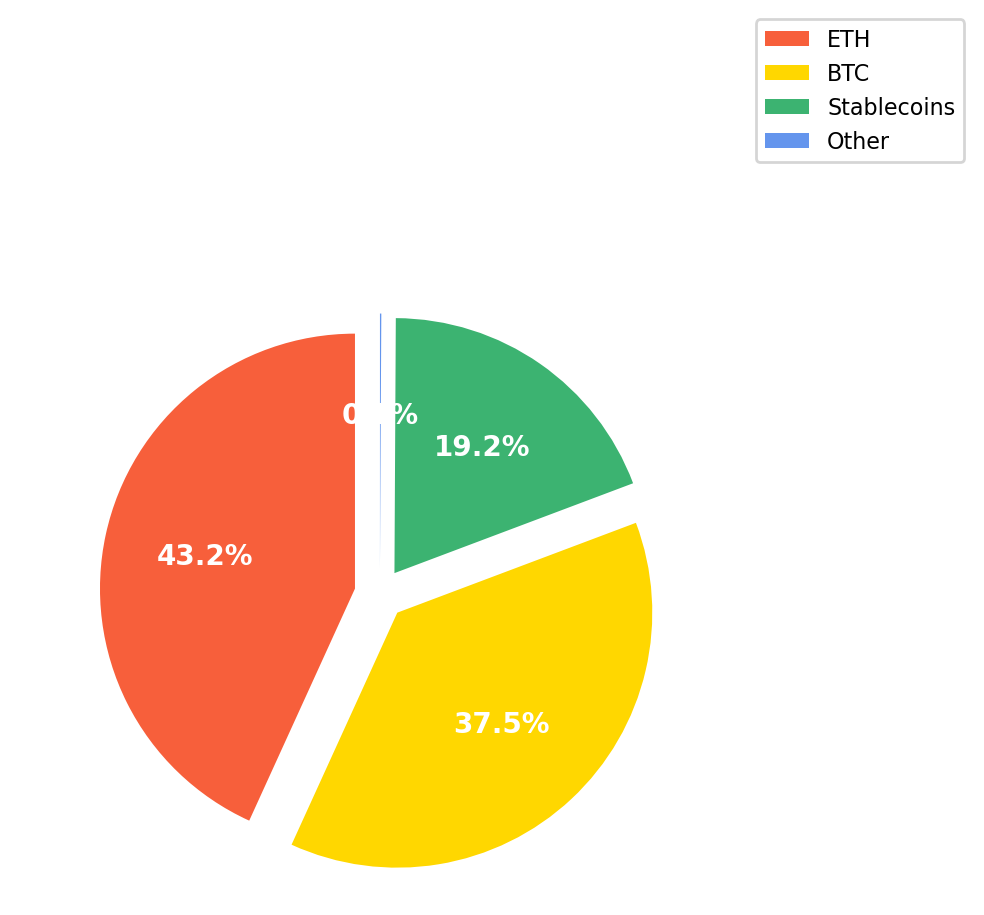

In [15]:
labels = 'ETH', 'BTC', 'Stablecoins', 'Other'
sizes = grouped_results_df['Total Amount (USD Value at Donation Time)']

chart_ETH = float(grouped_results_df['Total Amount (USD Value at Donation Time)'][0])
chart_BTC = float(grouped_results_df['Total Amount (USD Value at Donation Time)'][1])
chart_Stab = float(grouped_results_df['Total Amount (USD Value at Donation Time)'][2])
chart_Rem = float(grouped_results_df['Total Amount (USD Value at Donation Time)'][3])

chartinput= [chart_ETH,chart_BTC,chart_Stab,chart_Rem]

colors = ['#F75F3B', 'gold', 'mediumseagreen','cornflowerblue']


explode = (0.1, 0.1, 0.1, 0.1)

textprops={"color":"white","weight":"bold"}  


fig1, ax1 = plt.subplots(figsize=(4, 4), dpi=200)
ax1.pie(sizes, explode=explode, labels=labels, colors=colors , autopct='%1.1f%%',
        shadow=False, startangle=90, textprops = textprops )
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.legend(title = "Variation Rate")

plt.legend(bbox_to_anchor=(1.45, 1.45 ), loc='upper right', borderaxespad=0, fontsize=8)
plt.title
plt.show()


#grouped_results_df.plot(kind='pie', y='Total Amount (USD Value at Donation Time)', autopct='%1.0f%%',colors = ['gold', 'lightgrey', 'mediumseagreen','cornflowerblue'],title='Cummulated Amount donated to Addresses know to be belonging to Ukraine (valued in USD at Donation Time)',explode = explode)